In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
import gym
import numpy as np
import nengo
import scipy.special

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

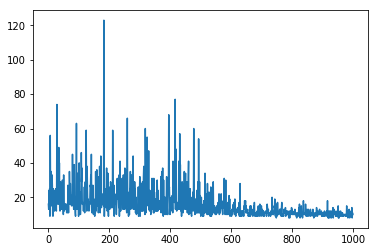

In [83]:
seed = 543

env = gym.make('CartPole-v0')
env.seed(seed)

class Policy(object):
    def __init__(self, n_neurons=128, dimensions=4, seed=543):
        self.model = nengo.Network(seed=seed)
        with self.model:
            self.ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions, 
                                      neuron_type=nengo.RectifiedLinear())
        self.sim = nengo.Simulator(self.model)
        
        self.w = np.zeros((3, n_neurons))
        
    def forward(self, x):
        _, act = nengo.utils.ensemble.tuning_curves(self.ens, self.sim, inputs=x)
        y = self.w.dot(act)
        return y
    
    def train(self, x, error, learning_rate=1e-4):
        _, act = nengo.utils.ensemble.tuning_curves(self.ens, self.sim, inputs=x)
        
        delta = error.T.dot(act)
        self.w += -learning_rate*delta
        
        
def log_prob(probs):
    eps = 1e-6
    p = np.clip(probs, eps, 1-eps)
    return np.log(p)
    
def select_action(state):
    y = p.forward(state)
    probs = y[:-1]
    probs = scipy.special.softmax(probs)
    action = np.random.choice(np.arange(2), p=probs)
    log_probs = log_prob(probs)
    value = y[-1]
    return action, log_probs[action], value

def do_episode():
    history = []
    state = env.reset()
    ep_reward = 0
    for i in range(9999):
        action, log_prob, value = select_action(state)
        state2, reward, done, _ = env.step(action)        
        history.append((state, action, state2, reward, log_prob, value))
        if done:
            break
    return history

def do_training(history, gamma=0.99, learning_rate=1e-4):
    returns = []
    R = 0
    for h in history[::-1]:
        r = h[3]
        R = r + gamma * R
        returns.insert(0, R)
    returns = np.array(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-6)
    
    train_state = []
    train_error = []
    for i, h in enumerate(history):
        R = returns[i]
        value = h[5]
        advantage = R - value
        action = h[1]
        state = h[0]
        log_prob = h[4]
        error_action = np.zeros(2)
        error_action[action] = -log_prob * advantage
        
        error_value = value - R
        error = np.hstack([error_action, error_value])
        train_state.append(state)
        train_error.append(error)
    
    p.train(np.array(train_state), np.array(train_error), learning_rate=learning_rate)
        

p = Policy()

rs = []
for i in range(1000):
    h = do_episode()
    rs.append(len(h))
    do_training(h, gamma=0.99, learning_rate=1e-8)
    
plt.plot(rs)

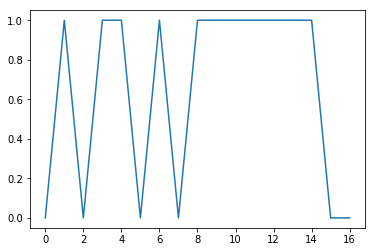

In [55]:
plt.plot([hh[1] for hh in h])

In [43]:
from torch.distributions import Categorical
import torch

probs = torch.from_numpy(np.array([0.2, 0.8])).float()

m = Categorical(probs)

action = m.sample()

print(m.log_prob(action))

tensor(-0.2231)
